In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [2]:
try:
    train_df = pd.read_csv('train_motion_data.csv')
    test_df = pd.read_csv('test_motion_data.csv')
    print("Train and test data loaded successfully.")
    print(f"Training data shape: {train_df.shape}")
    print(f"Testing data shape: {test_df.shape}\n")
except FileNotFoundError:
    print("Error: Make sure 'train_motion_data.csv' and 'test_motion_data.csv' are in the same directory.")
    exit()

train_df

Train and test data loaded successfully.
Training data shape: (3644, 8)
Testing data shape: (3084, 8)



,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,NORMAL,3581629
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,NORMAL,3581630
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,NORMAL,3581630
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,NORMAL,3581631
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,NORMAL,3581631
...,...,...,...,...,...,...,...,...
3639,0.915688,-2.017489,1.687505,0.450360,0.384845,-1.236468,SLOW,3583789
3640,-1.934203,0.914925,-0.096013,0.321468,0.649350,-0.477162,SLOW,3583790
3641,-0.222845,0.747304,-0.887430,0.361174,-0.406836,0.054291,SLOW,3583790
3642,-0.349423,0.067261,0.394368,-0.132405,0.020159,-0.004963,SLOW,3583791


In [3]:
# Define features (X) and target (y)
features = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ','Timestamp']
target = 'Class'

# Get train and test subsets 
X_train = train_df[features]
y_train_labels = train_df[target]
X_test = test_df[features]
y_test_labels = test_df[target]

# Encode labels into numbers that can be processed by various ML models.
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

# scale X training data only to ensure data is within similar values 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
# --- Hyperparameter Tuning ---
# X_train_scaled, y_train


# --- 1. Tuning SVM ---
print("--- Starting SVM Tuning (This may take a while)... ---")

# Define the 'grid' of parameters to search
# C: Regularization parameter.
# gamma: Kernel coefficient.
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf']
}

# Create the GridSearchCV object
# cv=3 means 3-fold cross-validation
svm_grid_search = GridSearchCV(estimator=SVC(random_state=42),
                               param_grid=svm_param_grid,
                               cv=3,
                               scoring='accuracy',
                               verbose=0,
                               n_jobs=-1) # Use all available CPU cores

# Fit the grid search to the training data
# This is the step that takes a long time
svm_grid_search.fit(X_train_scaled, y_train)

# After fitting, you would find the best parameters and score
print(f"Best SVM Parameters: {svm_grid_search.best_params_}")
print(f"Best SVM Cross-Validation Accuracy: {svm_grid_search.best_score_}")

# --- 2. Tuning Random Forest ---
print("\n--- Starting Random Forest Tuning (This may also take a while)... ---")

# Define the 'grid' of parameters to search
# n_estimators: Number of trees in the forest.
# max_depth: Maximum depth of each tree.
# min_samples_leaf: Minimum samples required at a leaf node.
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 40, None],
    'min_samples_leaf': [1, 2, 4, 6, 8, 12, 14, 16]
}

# Create the GridSearchCV object
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=rf_param_grid,
                              cv=3,
                              scoring='accuracy',
                              verbose=0,
                              n_jobs=-1)

# Fit the grid search to the training data
rf_grid_search.fit(X_train_scaled, y_train)

# After fitting, you would find the best parameters and score
print(f"Best Random Forest Parameters: {rf_grid_search.best_params_}")
print(f"Best Random Forest Cross-Validation Accuracy: {rf_grid_search.best_score_}")

print("\n--- Tuning Example Complete ---")
print("To get results, uncomment the '.fit()' lines and run the code.")



--- Starting SVM Tuning (This may take a while)... ---
Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM Cross-Validation Accuracy: 0.8257510729613733

--- Starting Random Forest Tuning (This may also take a while)... ---
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 16, 'n_estimators': 100}
Best Random Forest Cross-Validation Accuracy: 0.8918454935622316

--- Tuning Example Complete ---
To get results, uncomment the '.fit()' lines and run the code.


Best overall model: Random Forest
Best Parameters: RandomForestClassifier(max_depth=10, min_samples_leaf=16, random_state=42)


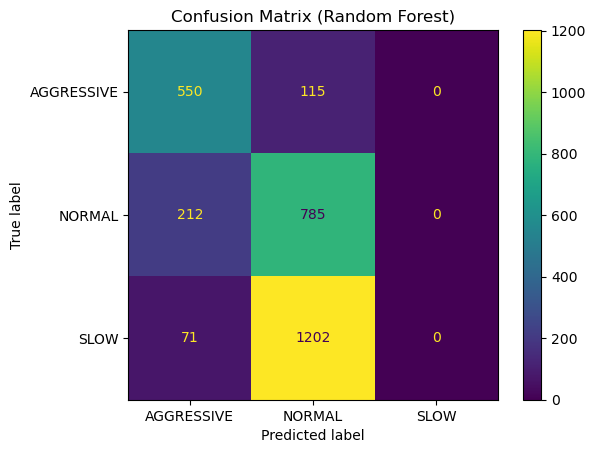

In [49]:
# Determine which tuned model was best
svm_best_score = svm_grid_search.best_score_
rf_best_score = rf_grid_search.best_score_

if svm_best_score >= rf_best_score:
    best_model = svm_grid_search.best_estimator_
    best_name = "SVM"
else:
    best_model = rf_grid_search.best_estimator_
    best_name = "Random Forest"

print(f"Best overall model: {best_name}")
print(f"Best Parameters: {best_model}")

# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.title(f"Confusion Matrix ({best_name})")
plt.show()


In [5]:
best_estimator = rf_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# This is quite low 

0.32555123216601817


In [6]:
# New approach 

WINDOW_SIZE = 150

def create_time_series_features(df, feature_cols, window_size):
    """
    Creates time-series features based on a rolling window.
    """
    print(f"\n--- Engineering features with window size {window_size} ---")
    df_sorted = df.sort_values(by=timestamp_col).copy()

    df_out = df_sorted[[timestamp_col, target_col]].copy()

    for col in feature_cols:
        # .rolling() creates the window object.
        # We then apply aggregate functions like .mean(), .std(), etc.
        df_out[f'{col}_mean_{window_size}'] = df_sorted[col].rolling(window=window_size).mean()
        df_out[f'{col}_std_{window_size}'] = df_sorted[col].rolling(window=window_size).std()
        df_out[f'{col}_max_{window_size}'] = df_sorted[col].rolling(window=window_size).max()
        df_out[f'{col}_min_{window_size}'] = df_sorted[col].rolling(window=window_size).min()

    df_out = df_out.dropna()

    return df_out



In [7]:
try:
    train_df = pd.read_csv("train_motion_data.csv")
    test_df = pd.read_csv("test_motion_data.csv")
    
except Exception as e:
    print(f"Error loading train_motion_data.csv: {e}")
    # Handle error appropriately

print(f"Original shape: {train_df.shape}")

feature_cols = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
# Define the target and timestamp
target_col = 'Class'
timestamp_col = 'Timestamp'

df_train_engineered = create_time_series_features(train_df, feature_cols, WINDOW_SIZE)
df_test_engineered = create_time_series_features(test_df,feature_cols, WINDOW_SIZE)




Original shape: (3644, 8)

--- Engineering features with window size 150 ---

--- Engineering features with window size 150 ---


In [8]:
# Define features (X) and target (y)
features = df_train_engineered.columns.to_list();
features.remove('Class')
target = 'Class'

# Get train and test subsets 
X_train = df_train_engineered[features]
y_train_labels = df_train_engineered[target]
X_test = df_test_engineered[features]
y_test_labels = df_test_engineered[target]

# Encode labels into numbers that can be processed by various ML models.
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

# scale X training data only to ensure data is within similar values 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# --- 2. Tuning Random Forest ---
print("\n--- Starting Random Forest Tuning (This may also take a while)... ---")

# Define the 'grid' of parameters to search
# n_estimators: Number of trees in the forest.
# max_depth: Maximum depth of each tree.
# min_samples_leaf: Minimum samples required at a leaf node.
rf_param_grid_regularized = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 8],          # <-- MUCH SMALLER DEPTHS
    'min_samples_leaf': [20, 50, 100]  # <-- MUCH LARGER LEAVES
}

# Create the GridSearchCV object
rf_grid_search_engineered = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=rf_param_grid,
                              cv=3,
                              scoring='accuracy',
                              verbose=0,
                              n_jobs=-1)

# Fit the grid search to the training data
rf_grid_search_engineered.fit(X_train_scaled, y_train)

# After fitting, you would find the best parameters and score
print(f"Best Random Forest Parameters: {rf_grid_search_engineered.best_params_}")
print(f"Best Random Forest Cross-Validation Accuracy: {rf_grid_search_engineered.best_score_}")

print("\n--- Tuning Example Complete ---")
print("To get results, uncomment the '.fit()' lines and run the code.")


--- Starting Random Forest Tuning (This may also take a while)... ---
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 16, 'n_estimators': 100}
Best Random Forest Cross-Validation Accuracy: 0.8918454935622316

--- Tuning Example Complete ---
To get results, uncomment the '.fit()' lines and run the code.


In [10]:
from sklearn.metrics import classification_report


best_estimator = rf_grid_search_engineered.best_estimator_
y_pred = best_estimator.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred))

0.454855195911414
              precision    recall  f1-score   support

           0       0.66      0.83      0.73       665
           1       0.37      0.79      0.51       997
           2       0.00      0.00      0.00      1273

    accuracy                           0.45      2935
   macro avg       0.34      0.54      0.41      2935
weighted avg       0.28      0.45      0.34      2935



/home/brandon-worley/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/brandon-worley/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/brandon-worley/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# --- 2. Try Logistic Regression ---
print("\n--- Testing Logistic Regression (on engineered features)... ---")
# C is the inverse of regularization strength.
# Lower C = STRONGER regularization
log_reg_param_grid = {'C': [0.01, 0.1, 1, 10]}

log_reg_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=log_reg_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

log_reg_grid.fit(X_train_scaled, y_train)

print(f"Best Logistic Regression CV Score: {log_reg_grid.best_score_}")

# Test Logistic Regression
best_log_reg = log_reg_grid.best_estimator_
y_pred_log_reg = best_log_reg.predict(X_test_scaled)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)

print(f"Test Set Accuracy (Logistic Regression): {accuracy_log_reg}")
print(classification_report(y_test, y_pred_log_reg))

# --- 3. Try a Linear SVM ---
print("\n--- Testing Linear SVM (on engineered features)... ---")
svm_param_grid = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear']}

svm_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid=svm_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

svm_grid.fit(X_train_scaled, y_train)

print(f"Best Linear SVM CV Score: {svm_grid.best_score_}")

# Test SVM
best_svm = svm_grid.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"Test Set Accuracy (Linear SVM): {accuracy_svm}")
print(classification_report(y_test, y_pred_svm))


--- Testing Logistic Regression (on engineered features)... ---
Best Logistic Regression CV Score: 0.8595135908440629
Test Set Accuracy (Logistic Regression): 0.3396933560477002
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       665
           1       0.34      1.00      0.51       997
           2       0.00      0.00      0.00      1273

    accuracy                           0.34      2935
   macro avg       0.11      0.33      0.17      2935
weighted avg       0.12      0.34      0.17      2935


--- Testing Linear SVM (on engineered features)... ---


/home/brandon-worley/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/brandon-worley/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/brandon-worley/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Best Linear SVM CV Score: 0.8085836909871245
Test Set Accuracy (Linear SVM): 0.3396933560477002
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       665
           1       0.34      1.00      0.51       997
           2       0.00      0.00      0.00      1273

    accuracy                           0.34      2935
   macro avg       0.11      0.33      0.17      2935
weighted avg       0.12      0.34      0.17      2935



/home/brandon-worley/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/brandon-worley/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/brandon-worley/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [57]:
def knn_search(csv_path, target_column, k_values=range(1, 26, 2)):
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score

    # Load data
    df = pd.read_csv(csv_path)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Scale features (very important for KNN)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Track results
    results = []
    best_k = None
    best_accuracy = -1
    best_model = None

    # Train and evaluate each K
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)

        results.append((k, acc))
        print(f"K = {k:<3} → Accuracy = {acc:.4f}")

        # Check best
        if acc > best_accuracy:
            best_accuracy = acc
            best_k = k
            best_model = model

    print("\nBest Model:")
    print(f"K = {best_k}, Accuracy = {best_accuracy:.4f}")

    # Return best model + full results
    return best_model, results


In [59]:
best_model, results = knn_search(
    "train_motion_data.csv",
    target_column="Class",
    k_values=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 41, 51, 61, 71, 81, 91]
)


K = 1   → Accuracy = 0.8820
K = 3   → Accuracy = 0.9122
K = 5   → Accuracy = 0.9273
K = 7   → Accuracy = 0.9259
K = 9   → Accuracy = 0.9273
K = 11  → Accuracy = 0.9355
K = 13  → Accuracy = 0.9287
K = 15  → Accuracy = 0.9396
K = 17  → Accuracy = 0.9396
K = 19  → Accuracy = 0.9383
K = 21  → Accuracy = 0.9410
K = 23  → Accuracy = 0.9410
K = 25  → Accuracy = 0.9396
K = 27  → Accuracy = 0.9424
K = 29  → Accuracy = 0.9451
K = 31  → Accuracy = 0.9451
K = 33  → Accuracy = 0.9451
K = 35  → Accuracy = 0.9465
K = 41  → Accuracy = 0.9492
K = 51  → Accuracy = 0.9424
K = 61  → Accuracy = 0.9410
K = 71  → Accuracy = 0.9410
K = 81  → Accuracy = 0.9438
K = 91  → Accuracy = 0.9465

Best Model:
K = 41, Accuracy = 0.9492
